In [1]:
%pip install datasets
%pip install torchtext
%pip install -U torchdata
%pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
%pip install portalocker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 973.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may 

In [2]:
import pandas as pd
from datasets import load_dataset, load_from_disk
import datasets


# def create_dataframe(dataset, name):
#     df_rows = []
#     for example in dataset:
#         translation = example['translation']
#         de = translation['de']
#         en = translation['en']
#         df_rows.append({"de": de, "en": en})

#     df = pd.DataFrame(df_rows)
#     df.to_csv(f"{name}.csv", index=False)
#     return df


test = datasets.load_dataset("wmt16","de-en", split="test")
train = datasets.load_dataset("wmt16","de-en", split="train[:50000]")
val = datasets.load_dataset("wmt16","de-en", split="validation")

# test_df = create_dataframe(test, "test")
# train_df = create_dataframe(train, "train")
# val_df = create_dataframe(val, "val")

train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

# train_df = train_df.head(100)
# val_df = val_df.head(10)
# test_df = test_df.head(10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

In [3]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

In [4]:
class DataFrameDataset:
    def __init__(self, df, src_language, tgt_language):
        self.df = df
        self.src_language = src_language
        self.tgt_language = tgt_language

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df.iloc[idx][self.src_language], self.df.iloc[idx][self.tgt_language]

    def __iter__(self):
        for idx in range(len(self)):
            yield self[idx]

train_df_dataset = DataFrameDataset(train_df, "de", "en")
for data_sample in train_df_dataset:
    print(f"SRC: {data_sample[0]}")
    print(f"TGT: {data_sample[1]}")
    break

test_df_dataset = DataFrameDataset(test_df, "de", "en")
for data_sample in test_df_dataset:
    print(f"SRC: {data_sample[0]}")
    print(f"TGT: {data_sample[1]}")
    break

val_df_dataset = DataFrameDataset(val_df, "de", "en")
for data_sample in val_df_dataset:
    print(f"SRC: {data_sample[0]}")
    print(f"TGT: {data_sample[1]}")
    break

SRC: Wiederaufnahme der Sitzungsperiode
TGT: Resumption of the session
SRC: Obama empfängt Netanyahu
TGT: Obama receives Netanyahu
SRC: Die Premierminister Indiens und Japans trafen sich in Tokio.
TGT: India and Japan prime ministers meet in Tokyo


In [5]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:

        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = train_df_dataset
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [6]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [7]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
!pip install bert-score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.0 MB/s eta 0:00:00


In [8]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [9]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [10]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [11]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = train_df_dataset
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = val_df_dataset
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
 17%|█▋        | 1/6 [04:30<22:32, 270.53s/it]

Epoch: 1, Train loss: 5.756, Val loss: 6.721, Epoch time = 267.004s


 33%|███▎      | 2/6 [08:58<17:56, 269.20s/it]

Epoch: 2, Train loss: 4.765, Val loss: 6.332, Epoch time = 265.123s


 50%|█████     | 3/6 [13:26<13:25, 268.62s/it]

Epoch: 3, Train loss: 4.342, Val loss: 6.077, Epoch time = 264.563s


 67%|██████▋   | 4/6 [17:54<08:56, 268.19s/it]

Epoch: 4, Train loss: 4.002, Val loss: 5.905, Epoch time = 264.446s


 83%|████████▎ | 5/6 [22:22<04:28, 268.34s/it]

Epoch: 5, Train loss: 3.718, Val loss: 5.876, Epoch time = 265.493s


100%|██████████| 6/6 [26:49<00:00, 268.27s/it]

Epoch: 6, Train loss: 3.470, Val loss: 5.820, Epoch time = 263.711s


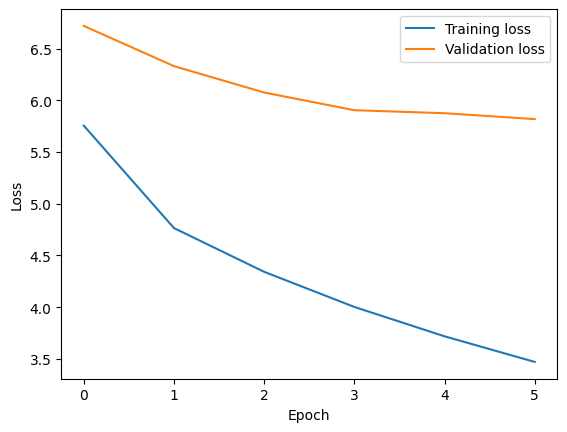

In [12]:
from timeit import default_timer as timer
from tqdm import tqdm

NUM_EPOCHS = 6

train_losses = []
val_losses = []

for epoch in tqdm(range(1, NUM_EPOCHS+1)):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    train_losses.append(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer)
    val_losses.append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [18]:
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': transformer.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, "Model_Setup_2A.pt")

In [19]:
# Move the model to the desired device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Load the checkpoint
checkpoint = torch.load("Model_Setup_2A.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

model.eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [17]:
# model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
#                                     NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# checkpoint = torch.load("Model_Setup_2A.pt")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']

# model.eval()

In [20]:
# sample german text
src_text = "Eine Gruppe von Menschen steht vor einem Iglu .."
translated_text = translate(model, src_text)

print(f"SRC: {src_text}")
print(f"TRG: {translated_text}")

SRC: Eine Gruppe von Menschen steht vor einem Iglu ..
TRG:  A group of people is being a good thing . 


In [21]:
import pandas as pd
from tqdm import tqdm

val_data = pd.read_csv('val.csv')
test_data = pd.read_csv('test.csv')

val_translated_A = val_data.copy()
test_translated_A = test_data.copy()

# add a new column of translated sentences as pred_en
val_translated_A['pred_en'] = val_translated_A['de'].apply(lambda x: translate(model, x))
test_translated_A['pred_en'] = test_translated_A['de'].apply(lambda x: translate(model, x))

val_translated_A.to_csv('val_translated_A.csv', index=False)
test_translated_A.to_csv('test_translated_A.csv', index=False)

In [22]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk import word_tokenize
import numpy as np
from tqdm import tqdm  # Make sure to import tqdm

def calculate_bleu_score(data):
    bleu_scores = []
    for _, row in tqdm(data.iterrows()):  # Added tqdm for progress tracking
        reference = row['en']  # Corrected the typo in variable name
        candidate = row['pred_en']
        bleu_1 = sentence_bleu([word_tokenize(reference)], word_tokenize(candidate), weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)
        bleu_2 = sentence_bleu([word_tokenize(reference)], word_tokenize(candidate), weights=(0.5, 0.5, 0, 0), smoothing_function=SmoothingFunction().method1)
        bleu_3 = sentence_bleu([word_tokenize(reference)], word_tokenize(candidate), weights=(0.333, 0.333, 0.333, 0), smoothing_function=SmoothingFunction().method1)  # Improved precision
        bleu_4 = sentence_bleu([word_tokenize(reference)], word_tokenize(candidate), weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=SmoothingFunction().method1)
        bleu_scores.append([bleu_1, bleu_2, bleu_3, bleu_4])
    return np.array(bleu_scores)

# Assuming val_translated_A and test_translated_A are defined elsewhere in your code
val_bleu_scores = calculate_bleu_score(val_translated_A)
test_bleu_scores = calculate_bleu_score(test_translated_A)

print(f"Val BLEU-1: {val_bleu_scores[:, 0].mean():.3f}")
print(f"Val BLEU-2: {val_bleu_scores[:, 1].mean():.3f}")
print(f"Val BLEU-3: {val_bleu_scores[:, 2].mean():.3f}")
print(f"Val BLEU-4: {val_bleu_scores[:, 3].mean():.3f}")

print(f"Test BLEU-1: {test_bleu_scores[:, 0].mean():.3f}")
print(f"Test BLEU-2: {test_bleu_scores[:, 1].mean():.3f}")
print(f"Test BLEU-3: {test_bleu_scores[:, 2].mean():.3f}")
print(f"Test BLEU-4: {test_bleu_scores[:, 3].mean():.3f}")


2169it [00:05, 415.93it/s]
2999it [00:05, 514.00it/s]

Val BLEU-1: 0.236
Val BLEU-2: 0.096
Val BLEU-3: 0.048
Val BLEU-4: 0.030
Test BLEU-1: 0.236
Test BLEU-2: 0.099
Test BLEU-3: 0.049
Test BLEU-4: 0.030


In [23]:
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import pandas as pd

# Assuming val_translated_A and test_translated_A are defined and correctly formatted as described

# Convert columns to lists and tokenize
references_val = [word_tokenize(ref) for ref in val_translated_A['en'].tolist()]
candidates_val = [word_tokenize(cand) for cand in val_translated_A['pred_en'].tolist()]

references_test = [word_tokenize(ref) for ref in test_translated_A['en'].tolist()]
candidates_test = [word_tokenize(cand) for cand in test_translated_A['pred_en'].tolist()]

# Function to calculate average METEOR score with tokenized input
def average_meteor(references, candidates):
    scores = [meteor_score([ref], cand) for ref, cand in zip(references, candidates)]
    return sum(scores) / len(scores)

# Calculate average METEOR scores
val_meteor_score = average_meteor(references_val, candidates_val)
test_meteor_score = average_meteor(references_test, candidates_test)

print("\nMETEOR Score for Validation Data: {:.4f}".format(val_meteor_score))
print("METEOR Score for Test Data: {:.4f}".format(test_meteor_score))



METEOR Score for Validation Data: 0.1904
METEOR Score for Test Data: 0.1959


In [24]:
# bert score

from bert_score import score
import pandas as pd

# Assuming val_translated_A and test_translated_A are defined and correctly formatted as described

# Convert columns to lists
references_val = val_translated_A['en'].tolist()
candidates_val = val_translated_A['pred_en'].tolist()

references_test = test_translated_A['en'].tolist()
candidates_test = test_translated_A['pred_en'].tolist()

# Calculate BERTScore
val_P, val_R, val_F1 = score(candidates_val, references_val, lang='en', verbose=True)
test_P, test_R, test_F1 = score(candidates_test, references_test, lang='en', verbose=True)

print("\nBERTScore for Validation Data:")
print(f"Precision: {val_P.mean():.4f}")
print(f"Recall: {val_R.mean():.4f}")
print(f"F1: {val_F1.mean():.4f}")

print("\nBERTScore for Test Data:")
print(f"Precision: {test_P.mean():.4f}")
print(f"Recall: {test_R.mean():.4f}")
print(f"F1: {test_F1.mean():.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/68 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/34 [00:00<?, ?it/s]

done in 23.78 seconds, 91.22 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/94 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/47 [00:00<?, ?it/s]

done in 30.13 seconds, 99.55 sentences/sec

BERTScore for Validation Data:
Precision: 0.8264
Recall: 0.8432
F1: 0.8346

BERTScore for Test Data:
Precision: 0.8255
Recall: 0.8408
F1: 0.8329
